# **Load estimation on a soft robot neck using machine learning techniques**

Author: Mariano González Gómez

The first part of the problem is to classify where the load is located within the platform. There are 4 possible outputs: 0, 1, 2, 3 -> center, M1, M2, M3.

The second part of the problem is to infer the weight of the mass. The data available goes from 0 to 700 gr.

# Libraries and data acquisition

The data set has been acquired in RoboticsLab in UC3M during the month of January, 2022 with a soft-neck prototype.

We aim to create a model that infers the position and weight of a load located on the upper platform of said soft-neck.

The input data of the model is the commanded orientation and inclination, and the real measured inclination for each orientation step, while the output data is the position and weight of the mass. That is to say, we want to infer the information of the mass from the differences between commanded and real measured inclination.




## Libraries

In [ ]:
!pip install pyts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 7.7 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from math import ceil
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, roc_auc_score, r2_score, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, KFold, LeaveOneOut, cross_val_score
from sklearn.linear_model import LogisticRegression, Lasso, LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor, VotingRegressor
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.gaussian_process.kernels import WhiteKernel, RationalQuadratic, ConstantKernel
from sklearn.gaussian_process import GaussianProcessClassifier, GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.base import BaseEstimator
from sklearn.utils.validation import (check_array, check_is_fitted, check_random_state)
from scipy.spatial import distance
from scipy.signal import lfilter
from pyts.classification import TimeSeriesForest
import joblib
from sklearn.base import TransformerMixin
import torch
from torch import nn
from torch import optim
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Data Acquisition

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Parameters
my_address = '/content/drive/MyDrive/Pesos_Cuello/Pesos_Nicole/' # For colab
# For local enviroment paste this to command prompt:
# jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0
#my_address = 'C:/Users/maria/Desktop/Uni/sofIA/Código/Datos_Nicole_Pesos/' # For local enviorment

weights = [0, 100, 200, 300, 400, 500, 600, 700]
positions = [0, 1, 2, 3]

i_range = np.arange(5, 51, 5)

theoretical_i = []
data_of_interest_per_o = []

# Loop to collect all the data we need to build later the desired dataframe
for w in weights:
  if w != 0:
    for p in positions:
      # Get real experimental values and erase columns we do not need
      data_r = pd.read_csv(my_address + 'w' + str(w) + '_p' + str(p) + '.csv')
      del data_r["M1"]
      del data_r["M2"]
      del data_r["M3"]

      # Get every value out of 100 (do not need time sampling)
      static_data = []
      for row in range(0, data_r.shape[0]):
        if row%100 == 0:
          static_data.append(data_r.iloc[row])

      # Get values of orientation
      for row in range(0, len(static_data), 36):
        data_of_interest_per_o.append([item[0] for item in static_data[row:row+36]])

      # Get theoretical values of inclination
      for i in i_range:
        theoretical_i.append([w, p, i])
  elif w == 0:  #Without weight, there is only one position (0)
    p = 0
    # Get real experimental values and erase columns we do not need
    data_r = pd.read_csv(my_address + 'w' + str(w) + '_p' + str(p) + '.csv')
    del data_r["M1"]
    del data_r["M2"]
    del data_r["M3"]

    # Get every value out of 100 (do not need time sampling)
    static_data = []
    for row in range(0, data_r.shape[0]):
      if row%100 == 0:
        static_data.append(data_r.iloc[row])

    # Get values of orientation
    for row in range(0, len(static_data), 36):
      data_of_interest_per_o.append([item[0] for item in static_data[row:row+36]])

    # Get theoretical values of inclination
    for i in i_range:
      theoretical_i.append([w, p, i])
      
# Create both dataframes and merge them into only one
df_i_r_per_o = pd.DataFrame(data_of_interest_per_o)
df_t = pd.DataFrame(theoretical_i)

df = pd.concat([df_t, df_i_r_per_o], axis = 1)

# To give names to the columns we do the following
names = ["w", "p", "i"]
for item in range(0, np.shape(data_of_interest_per_o)[1]):
  names.append("i_r_o" + str(item))

In [ ]:
df.columns = names
df.reset_index(drop=True, inplace=True)

for name in names[3:]:
  df['i -' + name] = df['i'] - df[name]
  del df[name]

In [ ]:
df

,w,p,i,i -i_r_o0,i -i_r_o1,i -i_r_o2,i -i_r_o3,i -i_r_o4,i -i_r_o5,i -i_r_o6,...,i -i_r_o26,i -i_r_o27,i -i_r_o28,i -i_r_o29,i -i_r_o30,i -i_r_o31,i -i_r_o32,i -i_r_o33,i -i_r_o34,i -i_r_o35
0,0,0,5,4.470955,0.898306,0.967419,0.841662,0.886368,0.991938,1.080058,...,0.937117,0.963745,0.931077,0.825535,0.769333,0.693609,0.616703,0.544077,0.520317,0.539839
1,0,0,10,5.577600,1.714465,1.811195,2.059392,2.339503,2.553457,2.883239,...,2.057709,2.083935,2.042053,1.901881,1.678472,1.488674,1.225852,1.128629,1.154151,1.292709
2,0,0,15,6.511969,2.865346,3.236745,3.638589,4.209105,4.471482,4.692154,...,3.334917,3.323367,3.279559,3.248931,2.854191,2.505734,2.216185,1.969168,2.024754,2.169669
3,0,0,20,7.496174,3.979452,4.483431,5.132781,5.672976,6.058041,6.181129,...,4.569592,4.615160,4.479682,4.373492,4.142721,3.658695,3.126898,2.833838,2.863553,3.199253
4,0,0,25,8.516859,5.325504,5.771744,6.540924,7.203473,7.614087,7.601073,...,4.952573,5.236308,5.489209,5.607289,5.469769,5.158470,4.661611,4.299003,4.379840,4.586821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,700,3,30,2.567754,-2.045764,-1.982647,-1.777128,-1.592951,-1.376650,-1.395353,...,4.970334,4.477425,3.595992,3.042603,2.326295,1.553950,0.455220,-0.300831,-1.100225,-1.725077
286,700,3,35,3.070303,-1.523626,-1.437273,-1.271452,-0.993844,-1.121970,-1.647309,...,6.695928,6.040376,5.303953,4.503789,3.509738,2.461213,1.349068,0.355414,-0.454599,-1.101826
287,700,3,40,3.504362,-0.963620,-0.929092,-0.685273,-0.596867,-0.951363,-1.803297,...,6.716489,6.181225,5.965844,5.429436,4.505874,3.521290,2.258609,1.196431,0.064268,-0.588054
288,700,3,45,3.994257,-0.522613,-0.116780,0.202005,0.071532,-0.557141,-1.595898,...,6.196323,6.219368,6.252170,6.190093,5.468961,4.222003,3.046557,1.630142,0.317531,-0.553388


## Data visualization

Text(0.5, 1.0, 'Inclination deviation along all orientation steps - UNFILTERED')

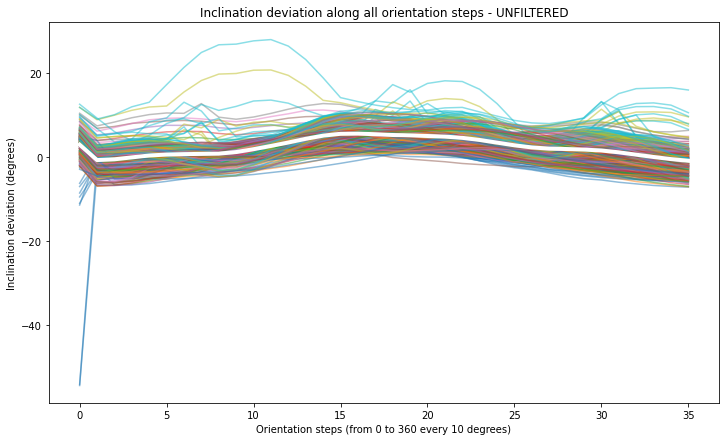

In [ ]:
df_new = df[df.columns[3:]].T.copy()

# Calculate mean of the deviations
mean = np.mean(df_new[df_new.columns[:]].values, axis = 1)

# Plot
plt.figure(figsize=(12, 7))
plt.plot(df_new[df_new.columns[:]].values, alpha = 0.5)
plt.plot(mean, "white", linewidth = 4)
plt.xlabel("Orientation steps (from 0 to 360 every 10 degrees)")
plt.ylabel("Inclination deviation (degrees)")
plt.title("Inclination deviation along all orientation steps - UNFILTERED")

## Preprocessing

In [ ]:
def preprocess(df_filt):

  # Erase first column because the sensor gives erratic values due to IMU sensor
  df_filt = df_filt.T.copy()
  del df_filt['i -i_r_o0']

  # Apply a FIR filter to smooth the peaks
  for idx, cycle in enumerate(df_filt.values.tolist()):
    n = 2 # The larger n is, the smoother curve will be
    b = [1.0 / n] * n
    a = 1
    y = cycle
    yy = lfilter(b,a,y)
    df_filt.iloc[idx] = yy

  return df_filt

In [ ]:
df_new = preprocess(df_new)

Text(0.5, 1.0, 'Inclination deviation along all orientation steps - FILTERED')

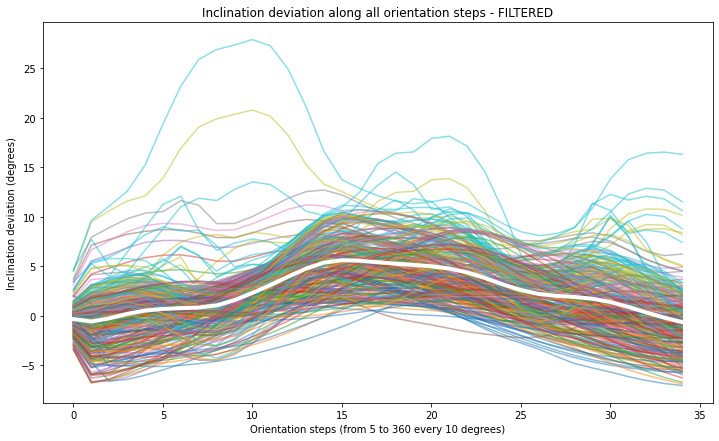

In [ ]:
df_new = df_new.T.copy()

# Calculate mean of the deviations
mean = np.mean(df_new[df_new.columns[:]].values, axis = 1)

# Plot
plt.figure(figsize=(12, 7))
plt.plot(df_new[df_new.columns[:]].values, alpha = 0.5)
plt.plot(mean, "white", linewidth = 4)
plt.xlabel("Orientation steps (from 5 to 360 every 10 degrees)")
plt.ylabel("Inclination deviation (degrees)")
plt.title("Inclination deviation along all orientation steps - FILTERED")

Text(0.5, 1.0, 'Inclination deviation along one orientation cycle of a theoretical inclination of 20 degrees depending on the position of a 600 grams load')

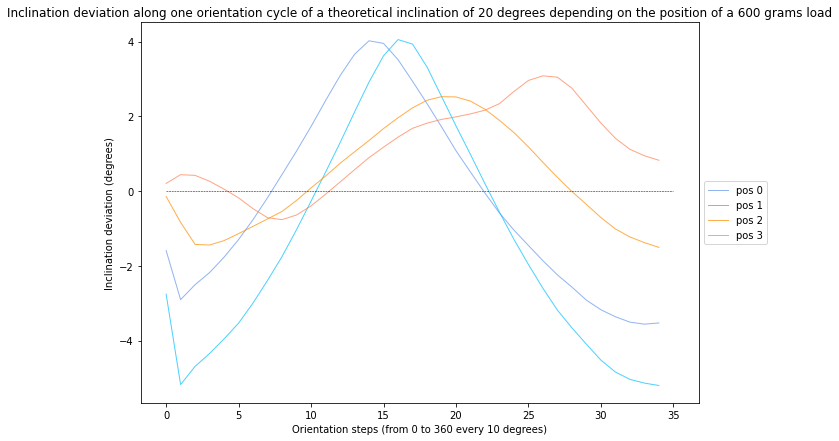

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(df_new[df_new.columns[50]].values, label = 'pos 0', color = "cornflowerblue", linewidth = 1, alpha = 0.7)
plt.plot(df_new[df_new.columns[60]].values, label = 'pos 1', color = "deepskyblue", linewidth = 1, alpha = 0.7)
plt.plot(df_new[df_new.columns[70]].values, label = 'pos 2', color = "darkorange", linewidth = 1, alpha = 0.7)
plt.plot(df_new[df_new.columns[80]].values, label = 'pos 3', color = "coral", linewidth = 1, alpha = 0.7)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.plot(np.zeros(36), 'k--', linewidth = 0.5)
plt.xlabel("Orientation steps (from 0 to 360 every 10 degrees)")
plt.ylabel("Inclination deviation (degrees)")
plt.title("Inclination deviation along one orientation cycle of a theoretical inclination of 20 degrees depending on the position of a 600 grams load")

Text(0, 0.5, 'Inclination deviation (degrees)')

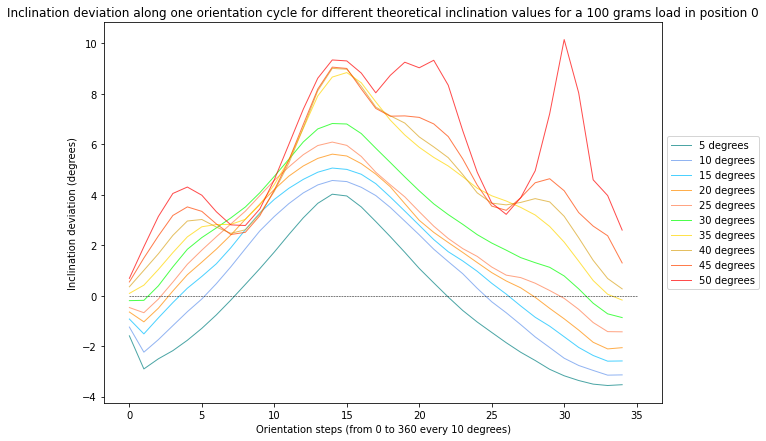

In [ ]:
colors = ["teal", "cornflowerblue", "deepskyblue", "darkorange", "coral", "lime", "gold", "goldenrod", "orangered", "red"]
plt.figure(figsize = (10,7))
plt.title("Inclination deviation along one orientation cycle for different theoretical inclination values for a 100 grams load in position 0")
for orient_cycle, c in zip(range(50,60), colors):
  plt.plot(df_new[df_new.columns[orient_cycle]].values, color = c, linewidth = 1, alpha = 0.7)
plt.plot(np.zeros(36), 'k--', linewidth = 0.5)
plt.legend(["5 degrees", "10 degrees", "15 degrees", "20 degrees", "25 degrees", "30 degrees", "35 degrees", "40 degrees", "45 degrees", "50 degrees"], loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Orientation steps (from 0 to 360 every 10 degrees)")
plt.ylabel("Inclination deviation (degrees)")

In [ ]:
df = df[df.columns[:3]].copy()
df = df.join(df_new.T)
df

,w,p,i,i -i_r_o1,i -i_r_o2,i -i_r_o3,i -i_r_o4,i -i_r_o5,i -i_r_o6,i -i_r_o7,...,i -i_r_o26,i -i_r_o27,i -i_r_o28,i -i_r_o29,i -i_r_o30,i -i_r_o31,i -i_r_o32,i -i_r_o33,i -i_r_o34,i -i_r_o35
0,0,0,5,0.449153,0.932862,0.904540,0.864015,0.939153,1.035998,1.097833,...,0.943604,0.950431,0.947411,0.878306,0.797434,0.731471,0.655156,0.580390,0.532197,0.530078
1,0,0,10,0.857233,1.762830,1.935293,2.199448,2.446480,2.718348,2.844274,...,2.021378,2.070822,2.062994,1.971967,1.790176,1.583573,1.357263,1.177240,1.141390,1.223430
2,0,0,15,1.432673,3.051045,3.437667,3.923847,4.340293,4.581818,4.659770,...,3.219710,3.329142,3.301463,3.264245,3.051561,2.679962,2.360959,2.092676,1.996961,2.097211
3,0,0,20,1.989726,4.231442,4.808106,5.402878,5.865509,6.119585,6.155695,...,4.455815,4.592376,4.547421,4.426587,4.258106,3.900708,3.392797,2.980368,2.848696,3.031403
4,0,0,25,2.662752,5.548624,6.156334,6.872198,7.408780,7.607580,7.606974,...,4.864031,5.094440,5.362758,5.548249,5.538529,5.314119,4.910040,4.480307,4.339422,4.483331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,700,3,30,-1.022882,-2.014205,-1.879887,-1.685039,-1.484801,-1.386002,-1.595315,...,5.378361,4.723880,4.036709,3.319297,2.684449,1.940122,1.004585,0.077194,-0.700528,-1.412651
286,700,3,35,-0.761813,-1.480450,-1.354363,-1.132648,-1.057907,-1.384639,-1.885867,...,7.098340,6.368152,5.672165,4.903871,4.006764,2.985476,1.905141,0.852241,-0.049592,-0.778212
287,700,3,40,-0.481810,-0.946356,-0.807183,-0.641070,-0.774115,-1.377330,-2.187015,...,6.914734,6.448857,6.073535,5.697640,4.967655,4.013582,2.889950,1.727520,0.630350,-0.261893
288,700,3,45,-0.261306,-0.319696,0.042613,0.136769,-0.242805,-1.076519,-2.017784,...,6.596445,6.207846,6.235769,6.221131,5.829527,4.845482,3.634280,2.338349,0.973836,-0.117928


# Classification problem

In [ ]:
# Obtain input features (X) and output features (Y)
X_p = df[df.columns[2:]].values
Y_p = df[df.columns[1]].values

# Split the data set into training and test data partitions
X_train, X_test, Y_p_train, Y_p_test = train_test_split(X_p, Y_p, test_size = 0.3, random_state = 0)

# Normalise data
transformer = StandardScaler()
X_train = transformer.fit_transform(X_train)
X_test =  transformer.transform(X_test)

# Normalise whole dataset (train + test) for whole prediction
X_p = transformer.transform(X_p)

## Feature-based models

### SVC

In [ ]:
# Parameters
parameters = [{'estimator__C': np.logspace(-3, 3, 10, base=10),
               'estimator__gamma': np.array([1e-4, 1e-3, 1e-2, 1e-1, 1])}]

In [ ]:
# Define and train the classifier
# Since SVC were designed for binary classification, we need to convert the problem in a set of binary ones
# We do this with OneVsOne strategy
stime = time.time()
clf_base = OneVsOneClassifier(SVC(kernel = 'rbf'))
clf_SVC = GridSearchCV(clf_base, parameters, cv = 5)
clf_SVC.fit(X_train, Y_p_train)
print("Best parameters:", clf_SVC.best_params_)

# Compute prediction and accuracy
Y_p_pred_SVC = clf_SVC.predict(X_test)
acc_test_SVC = accuracy_score(Y_p_test, Y_p_pred_SVC)
time_SVC = time.time() - stime

# Print results
print("Accuracy: %2.2f" %(acc_test_SVC))
print("Time: %2.2f" %(time_SVC))
conf_mat_SVC = confusion_matrix(Y_p_test, Y_p_pred_SVC)
#sns.heatmap(confusion_matrix(Y_p_test, Y_p_pred_SVC), annot=True, cmap='Blues');

Best parameters: {'estimator__C': 215.44346900318823, 'estimator__gamma': 0.01}
Accuracy: 0.95
Time: 3.77


In [ ]:
Y_p_pred_final_SVC = clf_SVC.predict(X_p)

### Extra Trees Classifier

In [ ]:
#Parameters to cross validate

params = {'n_estimators': [100, 200, 500],
          'max_depth': [12, 15, 18],
          'criterion': ['gini', 'entropy']}

In [ ]:
# Create Forest and fit data
stime = time.time()
clf_ET = GridSearchCV(ExtraTreesClassifier(random_state = 0), params, cv = 5)
clf_ET.fit(X_train, Y_p_train)
print("Best parameters:", clf_ET.best_params_)

# Compute accuracy
acc_test_ET = clf_ET.score(X_test, Y_p_test)

# Compute prediction
Y_p_pred_ET = clf_ET.predict(X_test)
time_ET = time.time() - stime

# Print results
print("Accuracy: %2.2f" %(acc_test_ET))
print("Time: %2.2f" %(time_ET))
conf_mat_ET = confusion_matrix(Y_p_test, Y_p_pred_ET)
#sns.heatmap(confusion_matrix(Y_p_test, Y_p_pred_ET), annot=True, cmap='Blues');

Best parameters: {'criterion': 'entropy', 'max_depth': 15, 'n_estimators': 100}
Accuracy: 0.92
Time: 22.13


In [ ]:
Y_p_pred_final_ET = clf_ET.predict(X_p)

### Time Series Forest Classifier

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

This transformer extracts 3 features from each window: the mean, the standard deviation and the slope. Then a random forest is built using these features as input data.

In [ ]:
params = {'n_estimators': [100, 200, 500],
          'max_depth': [12, 15, 18],
          'n_windows': [10, 12, 14],
          'min_window_size': [1, 3, 5]}

In [ ]:
# Create classifier and fit data
stime = time.time()
clf_TSF = GridSearchCV(TimeSeriesForest(), param_grid = params, cv = 5)
clf_TSF.fit(X_train, Y_p_train)
print("Best parameters:", clf_TSF.best_params_)

# Compute accuracy
acc_test_TSF = clf_TSF.score(X_test, Y_p_test)

# Compute prediction
Y_p_pred_TSF = clf_TSF.predict(X_test)
time_TSF = time.time() - stime

# Print results
print("Accuracy: %2.2f" %(acc_test_TSF))
print("Time: %2.2f" %(time_TSF))
conf_mat_TSF = confusion_matrix(Y_p_test, Y_p_pred_TSF)

Best parameters: {'max_depth': 18, 'min_window_size': 3, 'n_estimators': 100, 'n_windows': 10}
Accuracy: 0.91
Time: 153.11


In [ ]:
Y_p_pred_final_TSF = clf_TSF.predict(X_p)

## Distance-based models

### KNN Classifier with Euclidean distances

In [ ]:
# Parameters
params = {'n_neighbors': np.arange(1, 10)}

In [ ]:
# Define and train the classifier
stime = time.time()
clf_KNN = GridSearchCV(KNeighborsClassifier(metric = "euclidean"), params, cv = 5)
clf_KNN.fit(X_train, Y_p_train)
print("Best parameters:", clf_KNN.best_params_)

# Compute accuracy
acc_test_KNN = clf_KNN.score(X_test, Y_p_test)

# Compute prediction
Y_p_pred_KNN = clf_KNN.predict(X_test)
time_KNN = time.time() - stime

# Print results
print("Accuracy: %2.2f" %(acc_test_KNN))
print("Time: %2.2f" %(time_KNN))
conf_mat_KNN = confusion_matrix(Y_p_test, Y_p_pred_KNN)
#sns.heatmap(confusion_matrix(Y_p_test, Y_p_pred_KNN), annot=True, cmap='Blues');

Best parameters: {'n_neighbors': 1}
Accuracy: 0.86
Time: 0.11


In [ ]:
Y_p_pred_final_KNN = clf_KNN.predict(X_p)

### KNN Classifier with Cosine distances

Cosine because in the case of the position estimation we only need the simmilarity among the sequences despite the magnitude.

In [ ]:
# Parameters
params = {'n_neighbors': np.arange(1, 10)}

In [ ]:
# Define and train the classifier
stime = time.time()
clf_KNN_cos = GridSearchCV(KNeighborsClassifier(metric = "cosine"), params, cv = 5)
clf_KNN_cos.fit(X_train, Y_p_train)
print("Best parameters:", clf_KNN_cos.best_params_)

# Compute prediction
Y_p_pred_KNN_cos = clf_KNN_cos.predict(X_test)
time_KNN_cos = time.time() - stime

# Compute accuracy
acc_test_KNN_cos = accuracy_score(Y_p_test, Y_p_pred_KNN_cos)

# Print results
print("Accuracy: %2.2f" %(acc_test_KNN_cos))
print("Time: %2.2f" %(time_KNN_cos))
conf_mat_KNN_cos = confusion_matrix(Y_p_test, Y_p_pred_KNN_cos)
#sns.heatmap(confusion_matrix(Y_p_test, Y_p_pred_KNN_cos), annot=True, cmap='Blues');

Best parameters: {'n_neighbors': 1}
Accuracy: 0.91
Time: 0.09


In [ ]:
Y_p_pred_final_KNN_cos = clf_KNN_cos.predict(X_p)

## Model-based models

### Gaussian Process Classifier

In [ ]:
from sklearn.gaussian_process.kernels import WhiteKernel, RationalQuadratic, ConstantKernel
warnings.filterwarnings('ignore')

kernel_RQ = RationalQuadratic()
Noise = WhiteKernel()
C = ConstantKernel()

In [ ]:
# Define and train the classifier
stime = time.time()
clf_GP = GaussianProcessClassifier(kernel = C*kernel_RQ + Noise, n_restarts_optimizer = 5, max_iter_predict = 200, random_state = 0)
clf_GP.fit(X_train, Y_p_train)

# Compute accuracy
acc_test_GP = clf_GP.score(X_test, Y_p_test)

# Compute prediction
Y_p_pred_GP = clf_GP.predict(X_test)
time_GP = time.time() - stime

# Print results
print("Accuracy: %2.2f" %(acc_test_GP))
print("Time: %2.2f" %(time_GP))
conf_mat_GP = confusion_matrix(Y_p_test, Y_p_pred_GP)
#sns.heatmap(confusion_matrix(Y_p_test, Y_p_pred_GP), annot=True, cmap='Blues');

Accuracy: 0.98
Time: 8.59


In [ ]:
Y_p_pred_final_GP = clf_GP.predict(X_p)

## Validation and results

### LOOCV

We use Leave One Out Cross Validation technique since we have a very small dataset where performance is critical.

In [ ]:
# Code taken from https://medium.com/analytics-vidhya/generation-of-a-concatenated-confusion-matrix-in-cross-validation-912485c4a972 by Rukshani Somarathna

def evaluate_model(classif, data_x, data_y):
    cv = LeaveOneOut()

    predicted_targets = []
    actual_targets = []

    for train_ix, test_ix in cv.split(data_x):
        train_x, train_y, test_x, test_y = data_x[train_ix], data_y[train_ix], data_x[test_ix], data_y[test_ix]
        # Fit the classifier
        classifier = clone(classif)
        classifier = classifier.fit(train_x, train_y)
        # Predict the labels of the test set samples
        predicted_labels = classifier.predict(test_x)
        predicted_targets.append(predicted_labels)
        actual_targets.append(test_y)

    # Compute accuracy
    acc = accuracy_score(actual_targets, predicted_targets)

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(actual_targets, predicted_targets)

    return predicted_targets, actual_targets, acc, cnf_matrix 

In [ ]:
clf_SVC_ = SVC(kernel = "rbf", C = clf_SVC.best_params_["estimator__C"], gamma = clf_SVC.best_params_["estimator__gamma"])

pred_tar_SVC, act_targ_SVC, acc_SVC, conf_mat_SVC = evaluate_model(clf_SVC_, X_p, Y_p)

In [ ]:
clf_ET_ = ExtraTreesClassifier(n_estimators = clf_ET.best_params_["n_estimators"], max_depth = clf_ET.best_params_["max_depth"], criterion = clf_ET.best_params_["criterion"])

pred_tar_ET, act_targ_ET, acc_ET, conf_mat_ET = evaluate_model(clf_ET_, X_p, Y_p)

In [ ]:
clf_TSF_ = TimeSeriesForest(random_state = 0)

pred_tar_TSF, act_targ_TSF, acc_TSF, conf_mat_TSF = evaluate_model(clf_TSF_, X_p, Y_p)

In [ ]:
clf_KNN_ = KNeighborsClassifier(metric = "euclidean", n_neighbors = clf_KNN.best_params_["n_neighbors"])

pred_tar_KNN, act_targ_KNN, acc_KNN, conf_mat_KNN = evaluate_model(clf_KNN_, X_p, Y_p)

In [ ]:
clf_KNN_cos_ = KNeighborsClassifier(metric = "cosine", n_neighbors = clf_KNN_cos.best_params_["n_neighbors"])

pred_tar_KNN_cos, act_targ_KNN_cos, acc_KNN_cos, conf_mat_KNN_cos = evaluate_model(clf_KNN_cos_, X_p, Y_p)

In [ ]:
clf_GP_ = GaussianProcessClassifier(kernel = C*kernel_RQ + Noise, n_restarts_optimizer = 5, max_iter_predict = 200, random_state = 0)

pred_tar_GP, act_targ_GP, acc_GP, conf_mat_GP = evaluate_model(clf_GP_, X_p, Y_p)

### Results LOOCV

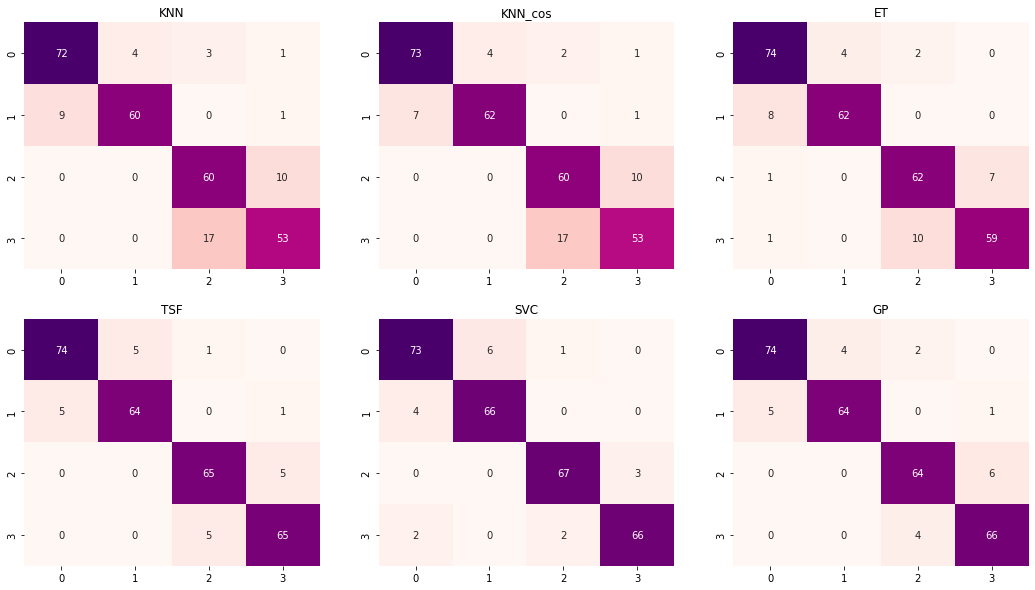

In [ ]:
# Confusion matrices
plt.figure(figsize=(18, 10))

plt.subplot(2, 3, 1)
plt.title("KNN")
sns.heatmap(conf_mat_KNN, annot=True, cmap='RdPu', cbar = False);

plt.subplot(2, 3, 2)
plt.title("KNN_cos")
sns.heatmap(conf_mat_KNN_cos, annot=True, cmap='RdPu', cbar = False);

plt.subplot(2, 3, 3)
plt.title("ET")
sns.heatmap(conf_mat_ET, annot=True, cmap='RdPu', cbar = False);

plt.subplot(2, 3, 4)
plt.title("TSF")
sns.heatmap(conf_mat_TSF, annot=True, cmap='RdPu', cbar = False);

plt.subplot(2, 3, 5)
plt.title("SVC")
sns.heatmap(conf_mat_SVC, annot=True, cmap='RdPu', cbar = False);

plt.subplot(2, 3, 6)
plt.title("GP")
sns.heatmap(conf_mat_GP, annot=True, cmap='RdPu', cbar = False);

In [ ]:
# Leave-One-Out cross validated accuracy, standard deviation and training time cost table
time_tot = np.sum([time_SVC, time_ET, time_TSF, time_KNN, time_KNN_cos, time_GP])

loocv_res = {"Accuracy": [acc_KNN, acc_KNN_cos, acc_ET, acc_TSF, acc_SVC, acc_GP], 
             "Training time cost over total time": 100*([time_KNN, time_KNN_cos, time_ET, time_TSF, time_SVC, time_GP]/time_tot)}

df_loocv_res = pd.DataFrame(loocv_res, index=pd.Index(['KNN', 'KNN_cos', 'ET', 'TSF', 'SVC', 'GP']), columns = ["Accuracy", "Training time cost over total time"])

df_loocv_res

,Accuracy,Training time cost over total time
KNN,0.844828,0.058106
KNN_cos,0.855172,0.049923
ET,0.886207,11.784808
TSF,0.924138,81.525578
SVC,0.937931,2.008782
GP,0.924138,4.572802


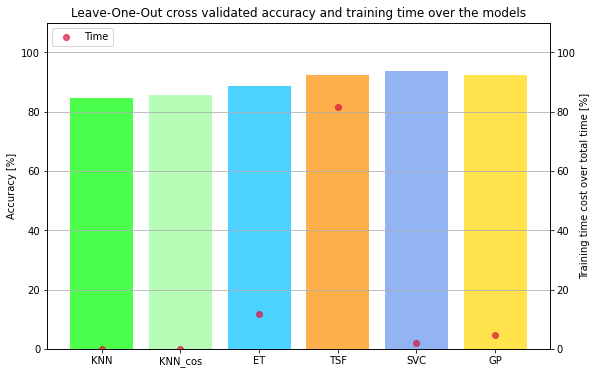

In [ ]:
# Plot of LOOCV results
colors = ["lime", "palegreen", "deepskyblue", "darkorange", "cornflowerblue", "gold"]

#---- Accuracy plot
fig, ax = plt.subplots(figsize=(9, 6))

X = ['KNN', 'KNN_cos', 'ET', 'TSF', 'SVC', 'GP']
X_axis = np.arange(len(X))

accLOOCV = [100*acc_KNN, 100*acc_KNN_cos, 100*acc_ET, 100*acc_TSF, 100*acc_SVC, 100*acc_GP]

ax.bar(X_axis, accLOOCV, label = 'Accuracy', color = colors, alpha = 0.7)

plt.ylim(0, 110)
plt.xticks(X_axis, X)
plt.ylabel("Accuracy [%]")
plt.title("Leave-One-Out cross validated accuracy and training time over the models")

#---- Times plot
ax2 = ax.twinx()

timeSpent = 100*([time_KNN, time_KNN_cos, time_ET, time_TSF, time_SVC, time_GP]/time_tot)

#ax2.plot(timeSpent, color = "crimson", alpha = 0.5)
ax2.scatter(X_axis, timeSpent, label = 'Time', color = "crimson", alpha = 0.7, marker = "o")

plt.ylim(0, 110)
plt.ylabel("Training time cost over total time [%]")
plt.grid()
plt.legend(loc = "upper left")

plt.show()

# Regression Problem

In [ ]:
# Obtain input features (X) and output features (Y)
X_w = df[df.columns[1:]].values
Y_w = df[df.columns[0]].values

# Split the data set into training and test data partitions
X_train, X_test, Y_w_train, Y_w_test = train_test_split(X_w, Y_w, test_size = 0.3, random_state = 0)

# Normalise data
transformer = StandardScaler()
X_train = transformer.fit_transform(X_train)
X_test =  transformer.transform(X_test)

# Normalise whole dataset (train + test) for whole prediction
X_w = transformer.transform(X_w)

## Feature-based models

### SVR

In [ ]:
# Parameters
parameters = [{'C': np.logspace(-3, 3, 10, base=10),
               'gamma': np.array([1e-4, 1e-3, 1e-2, 1e-1, 1])}]

In [ ]:
# Define and train the regressor
stime = time.time() 
reg_SVR = GridSearchCV(SVR(kernel = 'rbf'), parameters, cv = 5)
reg_SVR.fit(X_train, Y_w_train)
print("Best parameters:", reg_SVR.best_params_)

# Compute error
Y_w_pred_SVR = reg_SVR.predict(X_test)
MAE_SVR = mean_absolute_error(Y_w_test, Y_w_pred_SVR)
R2_SVR = r2_score(Y_w_test, Y_w_pred_SVR)
time_SVR = time.time() - stime

# Print results
print("MAE: %2.2f" %(MAE_SVR))
print("R2: %2.2f" %(R2_SVR))
print("Time: %2.2f" %(time_SVR))

Best parameters: {'C': 1000.0, 'gamma': 0.1}
MAE: 59.32
R2: 0.82
Time: 0.84


### Extra Trees Regressor

In [ ]:
#Parameters to cross validate

params = {'n_estimators': [100, 200, 300],
          'max_depth': [12, 15, 18, 21]}

In [ ]:
# Create Forest and fit data
stime = time.time()
reg_ET = GridSearchCV(ExtraTreesRegressor(criterion = "absolute_error"), params, cv = 5)
reg_ET.fit(X_train, Y_w_train)
print("Best parameters:", reg_ET.best_params_)

# Compute error
Y_w_pred_ET = reg_ET.predict(X_test)
MAE_ET = mean_absolute_error(Y_w_test, Y_w_pred_ET)
R2_ET = r2_score(Y_w_test, Y_w_pred_ET)
time_ET = time.time() - stime

# Print results
print("MAE: %2.2f" %(MAE_ET))
print("R2: %2.2f" %(R2_ET))
print("Time: %2.2f" %(time_ET))

Best parameters: {'max_depth': 12, 'n_estimators': 200}
MAE: 73.78
R2: 0.78
Time: 76.55


### Time Series Extra Trees Regressor

In [ ]:
# My own adaptation of """Code for Time Series Forest.""" for regression with Extra Trees (Features: mean, std, slope per window)

# Author: Johann Faouzi <johann.faouzi@gmail.com>
# License: BSD-3-Clause

In [ ]:
def extract_features(X, n_samples, n_windows, indices):
    X_new = np.empty((n_samples, 3 * n_windows))
    for j in range(n_windows):
        start, end = indices[j]
        arange = np.arange((start - end + 1) / 2, (end + 1 - start) / 2)
        if end - start == 1:
            var_arange = 1.
        else:
            var_arange = np.sum(arange ** 2)

        for i in range(n_samples):
            mean = np.mean(X[i, start:end])
            X_new[i, 3 * j] = mean
            X_new[i, 3 * j + 1] = np.std(X[i, start:end])
            X_new[i, 3 * j + 2] = (
                np.sum((X[i, start:end] - mean) * arange) / var_arange
            )

    return X_new

In [ ]:
class WindowFeatureExtractor(BaseEstimator):
  def __init__(self, n_windows=1., min_window_size=1, random_state=None):
    self.n_windows = n_windows
    self.min_window_size = min_window_size
    self.random_state = random_state

  def fit(self, X, y=None):
    n_timestamps = X.shape[1]
    n_windows, min_window_size, rng = self._check_params(X)
    # Generate the start and end indices
    start = rng.randint(0, n_timestamps - min_window_size, size=n_windows)
    end = rng.randint(start + min_window_size, n_timestamps + 1, size=n_windows)
    self.indices_ = np.c_[start, end]
    return self

  def transform(self, X):
    # Extract the features from each window
    n_samples = X.shape[0]
    n_windows = self.indices_.shape[0]
    return extract_features(X, n_samples, n_windows, self.indices_)
    
  def _check_params(self, X):
    n_samples, n_timestamps = X.shape

    if not isinstance(self.n_windows,
                      (int, np.integer, float, np.floating)):
        raise TypeError("'n_windows' must be an integer or a float.")
    if isinstance(self.n_windows, (int, np.integer)):
        if self.n_windows < 1:
            raise ValueError(
                "If 'n_windows' is an integer, it must be positive "
                "(got {0}).".format(self.n_windows)
            )
        n_windows = self.n_windows
    else:
        if self.n_windows <= 0:
            raise ValueError(
                "If 'n_windows' is a float, it must be greater "
                "than 0 (got {0}).".format(self.n_windows)
            )
        n_windows = ceil(self.n_windows * n_timestamps)

    if not isinstance(self.min_window_size,
                      (int, np.integer, float, np.floating)):
        raise TypeError("'min_window_size' must be an integer or a float.")
    if isinstance(self.min_window_size, (int, np.integer)):
        if not 1 <= self.min_window_size <= n_timestamps:
            raise ValueError(
                "If 'min_window_size' is an integer, it must be greater "
                "than or equal to 1 and lower than or equal to "
                "n_timestamps (got {0}).".format(self.min_window_size)
            )
        min_window_size = self.min_window_size
    else:
        if not 0 < self.min_window_size <= 1:
            raise ValueError(
                "If 'min_window_size' is a float, it must be greater "
                "than 0 and lower than or equal to 1 (got {}).".
                format(self.min_window_size)
            )
        min_window_size = ceil(self.min_window_size * n_timestamps)

    rng = check_random_state(self.random_state)

    return n_windows, min_window_size, rng


In [ ]:
class TimeSeriesExtraTreesRegresor(ExtraTreesRegressor):
  def __init__(self,
               n_estimators=100,
               max_depth=3,
               criterion="absolute_error",
               max_features=1.,
               n_windows=3,
               min_window_size=1.,
               random_state=0):
    super().__init__(n_estimators=n_estimators, max_depth=max_depth, max_features = max_features, criterion = criterion)
    self.n_windows = n_windows
    self.min_window_size = min_window_size
    self.random_state = random_state
    self.feature_extractor = None
    self.stdscaler = None

  def fit(self, X, y):
    self.feature_extractor = WindowFeatureExtractor(n_windows = self.n_windows, min_window_size = self.min_window_size, random_state = self.random_state).fit(X)
    X_new = self.feature_extractor.transform(X)
    self.stdscaler = StandardScaler()
    X_new = self.stdscaler.fit_transform(X_new)
    return super(TimeSeriesExtraTreesRegresor, self).fit(X_new, y)
   
  def predict(self, X):
    X_new = self.feature_extractor.transform(X)
    X_new = self.stdscaler.transform(X_new)
    return super(TimeSeriesExtraTreesRegresor, self).predict(X_new)

In [ ]:
#Parameters to cross validate

params = {'n_estimators': [100, 200, 300],
          'max_depth': [3, 15, 18, 21],
          'n_windows': [2, 10, 12, 14],
          'min_window_size': [1, 3, 5]}

In [ ]:
# Create Forest and fit data
stime = time.time()
reg_TSET = GridSearchCV(TimeSeriesExtraTreesRegresor(), params, cv = 5)
reg_TSET.fit(X_train, Y_w_train)
print("Best parameters:", reg_TSET.best_params_)

# Compute error
Y_w_pred_TSET = reg_TSET.predict(X_test)
MAE_TSET = mean_absolute_error(Y_w_test, Y_w_pred_TSET)
R2_TSET = r2_score(Y_w_test, Y_w_pred_TSET)
time_TSET = time.time() - stime

# Print results
print("MAE: %2.2f" %(MAE_TSET))
print("R2: %2.2f" %(R2_TSET))
print("Time: %2.2f" %(time_TSET))

Best parameters: {'max_depth': 18, 'min_window_size': 3, 'n_estimators': 300, 'n_windows': 12}
MAE: 67.55
R2: 0.80
Time: 710.17


### MLP Regressor

PYTORCH

In [ ]:
class MLP(nn.Module):
    def __init__(self, dim_feat, hidden1, hidden2, output=1, epochs=100, lr=0.0001, p = 0.2):
        super().__init__()

        # Hidden layers
        self.output1 = nn.Linear(dim_feat, hidden1)
        self.output2 = nn.Linear(hidden1, hidden2)
        self.output3 = nn.Linear(hidden2, output) # Output is 1 because it is regression
    
        # Activation function
        self.relu = nn.ReLU()

        # Dropout
        self.dropout = nn.Dropout(p)

        # Parameters
        # Learning rate
        self.lr = lr
        # Number of iterations
        self.epochs = epochs
        # MAE criterion
        self.criterion = nn.MSELoss()
        # Optimizer
        self.optim = optim.LBFGS(self.parameters(), self.lr)
        # A list to store the loss evolution along training   
        self.loss_during_training = []   
        self.valid_loss_during_training = []                                     
        
    def forward(self, x):
      # Pass the input tensor through each of our operations
      x = self.output1(x)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.output2(x)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.output3(x)
      return x
    
    def trainloop(self, x, x_val, y, y_val):
    # Optimization Loop
      for e in range(int(self.epochs)):

        # Reset gradients!
        self.optim.zero_grad() 

        # Convert data to tensors
        x = torch.Tensor(x).view(x.shape[0], -1)
        y = torch.Tensor(y).view(y.shape[0], -1)
        x_val = torch.Tensor(x_val).view(x_val.shape[0], -1)
        y_val = torch.Tensor(y_val).view(y_val.shape[0], -1)

        # Get the predicted output
        out = self.forward(x)

        # Get the error between the predicted output and the real one
        loss = self.criterion(out, y) 
        loss.backward()
              
        # Choose largest gradient and update the weights
        self.optim.step()
  
        self.loss_during_training.append(loss.item()/self.epochs)

        # Validation step
        with torch.no_grad():

          # Deactivate dropout for validation
          self.eval()

          # Calculate output for validation
          out_val = self.forward(x_val)

          # Get the error between the predicted output and the real one
          valid_loss = self.criterion(out_val, y_val)
          self.train()

        # Keep track of loss
        self.valid_loss_during_training.append(valid_loss.item()/self.epochs)
            
    def predict(self, x):
      preds = []

      # Convert data to tensor
      x = torch.Tensor(x).view(x.shape[0], -1)

      # Make predictions
      preds = self.forward(x)

      # Convert tensor to array
      preds = preds.detach().numpy()

      return preds

In [ ]:
# 80% train - 20% validation
X_train_mlp, X_val, Y_w_train_mlp, Y_val = train_test_split(X_train, Y_w_train, test_size = 0.2, random_state = 0)

# Normalise data
transformer = StandardScaler()
X_train_mlp = transformer.fit_transform(X_train_mlp)
X_val =  transformer.transform(X_val)

In [ ]:
# Number of hidden layers:
# 2 -> Can represent an arbitrary decision boundary to arbitrary accuracy
# Some rules for choosing number of neurons (From Introduction to Neural Networks for Java (second edition) by Jeff Heaton):
# The number of hidden neurons should be between the size of the input layer and the size of the output layer.
# The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
# The number of hidden neurons should be less than twice the size of the input layer.

# Create model and train it
reg_MLP = MLP(dim_feat = X_train_mlp.shape[1], hidden1 = int(X_train.shape[1]*2-1), hidden2 = X_train.shape[1], output = 1, epochs = 10000, lr = 0.001, p = 0.0)

reg_MLP.trainloop(X_train_mlp, X_val, Y_w_train_mlp, Y_val)

In [ ]:
# Prediction
Y_w_pred_MLP = reg_MLP.predict(X_test)

In [ ]:
plt.plot(reg_MLP.loss_during_training, label = 'Training loss')
plt.plot(reg_MLP.valid_loss_during_training, label = 'Validation loss')
plt.legend()

MAE_MLP = mean_absolute_error(Y_w_test, Y_w_pred_MLP)
R2_MLP = r2_score(Y_w_test, Y_w_pred_MLP)

print("MAE: ", MAE_MLP, "\nR2: ", R2_MLP)

SKLEARN

In [ ]:
# Parameters to cross validate
# Number of hidden layers:
# 2 -> Can represent an arbitrary decision boundary to arbitrary accuracy
# Some rules for choosing number of neurons (From Introduction to Neural Networks for Java (second edition) by Jeff Heaton):
# The number of hidden neurons should be between the size of the input layer and the size of the output layer.
# The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
# The number of hidden neurons should be less than twice the size of the input layer.

params = {'alpha': [0.01, 0.1, 1, 10],
          'hidden_layer_sizes': [(X_train.shape[1]/2, X_train.shape[1]/4), (X_train.shape[1]*2/3+1, X_train.shape[1]*2/6+1), (X_train.shape[1]*2-1, X_train.shape[1])]}

In [ ]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
# Create model and fit data
stime = time.time()
reg_MLP = GridSearchCV(MLPRegressor(max_iter = 100000, solver = 'lbfgs', warm_start = True, early_stopping = True, random_state = 0), params, cv = 5)
reg_MLP.fit(X_train, Y_w_train)
print("Best parameters:", reg_MLP.best_params_)

# Compute error
Y_w_pred_MLP = reg_MLP.predict(X_test)
MAE_MLP = mean_absolute_error(Y_w_test, Y_w_pred_MLP)
R2_MLP = r2_score(Y_w_test, Y_w_pred_MLP)
time_MLP = time.time() - stime

# Print results
print("MAE: %2.2f" %(MAE_MLP))
print("R2: %2.2f" %(R2_MLP))
print("Time: %2.2f" %(time_MLP))


Best parameters: {'alpha': 1, 'hidden_layer_sizes': (73, 37)}
MAE: 45.88
R2: 0.91
Time: 370.63


### RNN Regressor

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, sigma):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.input_size = input_size
        # define a RNN with specified parameters
        # Add dropout to avoid overfitting
        # batch_first=True means that the first dimension of the input will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, nonlinearity='relu', batch_first=True)
        # fully-connected layer
        self.fc1 = nn.Linear(hidden_dim, output_size)
        # activation function
        self.act = nn.Softplus()
        # Noise parameter
        self.sigma = sigma

    def forward(self, x, h0=None, valid=False):
        
        batch_size = x.size(0) # Number of different sequences
        seq_length = x.size(1) # Length of the sequences

        # get RNN outputs
        # r_out is the sequence of states
        # hidden is just the last state
        r_out, hidden = self.rnn(x, h0)
        r_out = r_out.reshape(-1, self.hidden_dim)
        dense_output = self.fc1(hidden[-1])
        noise = torch.randn_like(dense_output)*self.sigma
        dense_output = dense_output + noise

        output = self.act(dense_output)
        output = output.reshape([batch_size])
        
        return output       

In [ ]:
class RNN_extended(RNN):
    def __init__(self, num_data_train, num_data_val, num_iter, sequence_length, input_size, output_size, hidden_dim, n_layers, sigma, lr=0.001):
        super().__init__(input_size, output_size, hidden_dim, n_layers, sigma) 
    
        self.hidden_dim = hidden_dim    
        self.sequence_length = sequence_length   
        self.num_layers = n_layers   
        self.lr = lr #Learning Rate 
        self.num_train = num_data_train #Number of training signals
        self.num_val = num_data_val #Number of validation signals
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.num_iter = num_iter
        self.criterion = nn.MSELoss()    
        self.loss_during_training = []
        self.valid_loss_during_training = []
           
    def trainloop(self, x, x_val, y, y_val):
        
        # SGD Loop
        for e in range(int(self.num_iter)):
        
            self.optim.zero_grad() 

            x = torch.Tensor(x).view([self.num_train, self.sequence_length, 1])
            y = torch.Tensor(y).view([self.num_train])
            x_val = torch.Tensor(x_val).view([self.num_val, self.sequence_length, 1])
            y_val = torch.Tensor(y_val).view([self.num_val])

            out = self.forward(x)
            
            out.view([self.num_train])

            loss = self.criterion(out, y) 
            loss.backward()
            
            # This code helps to avoid vanishing exploiting gradients in LSTMs
            nn.utils.clip_grad_norm_(self.parameters(), 2.0)
                
            self.optim.step()
      
            self.loss_during_training.append(loss.item()/self.num_iter)

            # Validation step
            with torch.no_grad():

                self.eval()

                # Calculate output and hidden states for validation set
                y_val = torch.Tensor(y_val)
                out = self.forward(x_val)
                out.view([self.num_val])

                valid_loss = self.criterion(out, y_val)
                self.train()

            # Keep track of loss
            self.valid_loss_during_training.append(valid_loss.item()/self.num_iter)

    def predict(self, x):
      X_in = torch.Tensor(x).view([-1, self.sequence_length, 1]) 
      o = self.forward(X_in)
      preds = o.detach().numpy()

      return preds

In [ ]:
# 80% to train and 20% to validation
X_train_rnn = X_train[:162]
X_val = X_train[162:]
Y_w_train_rnn = Y_w_train[:162]
Y_val = Y_w_train[162:]

In [ ]:
# Create model and train it
seq_len = X_train_rnn.shape[1]

my_RNN = RNN_extended(num_data_train = X_train_rnn.shape[0], num_data_val = X_val.shape[0], num_iter = 1000, sequence_length = seq_len,
                      input_size = 1, output_size = 1, hidden_dim = 32, n_layers = 1, sigma = 1.0, lr=0.0001)

my_RNN.trainloop(X_train_rnn, X_val, Y_w_train_rnn, Y_val)

In [ ]:
plt.plot(my_RNN.loss_during_training, label = 'Training loss')
plt.plot(my_RNN.valid_loss_during_training, label = 'Validation loss')
plt.legend()

In [ ]:
stop_epoch = np.argsort(my_RNN.valid_loss_during_training)[0]
print(stop_epoch)

In [ ]:
reg_RNN = RNN_extended(num_data_train = X_train_rnn.shape[0], num_data_val = X_val.shape[0], num_iter = stop_epoch, sequence_length = seq_len,
                       input_size = 1, output_size = 1, hidden_dim = 32, n_layers = 1, sigma = 1.0, lr=0.0001)

reg_RNN.trainloop(X_train_rnn, X_val, Y_w_train_rnn, Y_val)

In [ ]:
# Prediction
Y_w_pred_RNN = reg_RNN.predict(X_test)

In [ ]:
MAE_RNN = mean_absolute_error(Y_w_test, Y_w_pred_RNN)
R2_RNN = r2_score(Y_w_test, Y_w_pred_RNN)

# Print results
print("MAE: %2.2f" %(MAE_RNN))
print("R2: %2.2f" %(R2_RNN))

## Distance-based models

### KNN Regressor with Euclidean distances

In [ ]:
params = [{'n_neighbors': np.arange(1, 10)}]

In [ ]:
# Create regressor and train it
stime = time.time()
reg_base = KNeighborsRegressor(metric = "euclidean")
reg_KNN = GridSearchCV(reg_base, params, cv= 5)
reg_KNN.fit(X_train, Y_w_train)
print("Best parameters:", reg_KNN.best_params_)

# Compute error
Y_w_pred_KNN = reg_KNN.predict(X_test)
MAE_KNN = mean_absolute_error(Y_w_test, Y_w_pred_KNN)
R2_KNN = r2_score(Y_w_test, Y_w_pred_KNN)
time_KNN = time.time() - stime

# Print results
print("MAE: %2.2f" %(MAE_KNN))
print("R2: %2.2f" %(R2_KNN))
print("Time: %2.2f" %(time_KNN))

Best parameters: {'n_neighbors': 3}
MAE: 80.46
R2: 0.73
Time: 0.07


### KNN Regressor with Manhattan distances

Manhattan because it works better than Euclidean distances in higher dimensional data

In [ ]:
params = [{'n_neighbors': np.arange(1, 10)}]

In [ ]:
# Create regressor and train it
stime = time.time()
reg_base = KNeighborsRegressor(metric = "manhattan")
reg_KNN_cos = GridSearchCV(reg_base, params, cv= 5)
reg_KNN_cos.fit(X_train, Y_w_train)
print("Best parameters:", reg_KNN.best_params_)

# Compute error
Y_w_pred_KNN_cos = reg_KNN_cos.predict(X_test)
MAE_KNN_cos = mean_absolute_error(Y_w_test, Y_w_pred_KNN_cos)
R2_KNN_cos = r2_score(Y_w_test, Y_w_pred_KNN_cos)
time_KNN_cos = time.time() - stime

# Print results
print("MAE: %2.2f" %(MAE_KNN_cos))
print("R2: %2.2f" %(R2_KNN_cos))
print("Time: %2.2f" %(time_KNN_cos))

Best parameters: {'n_neighbors': 3}
MAE: 69.54
R2: 0.75
Time: 0.09


## Model-based models

### Gaussian Process Regressor

In [ ]:
from sklearn.gaussian_process.kernels import WhiteKernel, RationalQuadratic, ConstantKernel
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning) 

kernel_RQ = RationalQuadratic()
C = ConstantKernel()
Noise = WhiteKernel()

In [ ]:
# Define and train the classifier
stime = time.time()
reg_GP = GaussianProcessRegressor(kernel = C*kernel_RQ + Noise, n_restarts_optimizer = 20)
reg_GP.fit(X_train, Y_w_train)
print("Kernel:", reg_GP.kernel_)

# Compute error
Y_w_pred_GP, GP_std = reg_GP.predict(X_test, return_std = True)
MAE_GP = mean_absolute_error(Y_w_test, Y_w_pred_GP)
R2_GP = r2_score(Y_w_test, Y_w_pred_GP)
time_GP = time.time() - stime

# Print results
print("MAE: %2.2f" %(MAE_GP))
print("R2: %2.2f" %(R2_GP))
print("Time: %2.2f" %(time_GP))

Kernel: 316**2 * RationalQuadratic(alpha=0.406, length_scale=2.57) + WhiteKernel(noise_level=870)
MAE: 45.21
R2: 0.91
Time: 3.78


## Validation and Results

### LOOCV

In [ ]:
# Code adapted from https://medium.com/analytics-vidhya/generation-of-a-concatenated-confusion-matrix-in-cross-validation-912485c4a972 by Rukshani Somarathna
from sklearn.base import clone

def evaluate_model_reg(regress, data_x, data_y, type = "No GP"):
    cv = LeaveOneOut()

    predicted_targets = []
    predicted_targets_std = []
    actual_targets = []

    if type == "No GP":
      for train_ix, test_ix in cv.split(data_x):
          train_x, train_y, test_x, test_y = data_x[train_ix], data_y[train_ix], data_x[test_ix], data_y[test_ix]
          # Fit the regressor
          regressor = clone(regress)
          regressor = regressor.fit(train_x, train_y)
          # Predict the labels of the test set samples
          predicted_labels = regressor.predict(test_x)
          predicted_targets.append(predicted_labels)
          actual_targets.append(test_y)

      # Compute mae and r2
      mae = mean_absolute_error(actual_targets, predicted_targets)
      r2 = r2_score(actual_targets, predicted_targets)

      return predicted_targets, actual_targets, mae, r2

    else:
      for train_ix, test_ix in cv.split(data_x):
          train_x, train_y, test_x, test_y = data_x[train_ix], data_y[train_ix], data_x[test_ix], data_y[test_ix]
          # Fit the regressor
          regressor = clone(regress)
          regressor = regressor.fit(train_x, train_y)
          # Predict the labels of the test set samples
          predicted_labels, predicted_std = regressor.predict(test_x, return_std = True)
          predicted_targets.append(predicted_labels)
          predicted_targets_std.append(predicted_std)
          actual_targets.append(test_y)

      # Compute mae and r2
      mae = mean_absolute_error(actual_targets, predicted_targets)
      r2 = r2_score(actual_targets, predicted_targets)

      return predicted_targets, predicted_targets_std, actual_targets, mae, r2

In [ ]:
reg_SVR_ = SVR(kernel = "rbf", C = reg_SVR.best_params_["C"], gamma = reg_SVR.best_params_["gamma"])

pred_tar_SVR_r, act_targ_SVR_r, mae_SVR, r2_SVR = evaluate_model_reg(reg_SVR_, X_w, Y_w)

In [ ]:
reg_ET_ = ExtraTreesClassifier(n_estimators = reg_ET.best_params_["n_estimators"], max_depth = reg_ET.best_params_["max_depth"])

pred_tar_ET_r, act_targ_ET_r, mae_ET, r2_ET = evaluate_model_reg(reg_ET_, X_w, Y_w)

In [ ]:
reg_TSET_ = TimeSeriesExtraTreesRegresor(n_estimators = reg_TSET.best_params_["n_estimators"],
                                        max_depth = reg_TSET.best_params_["max_depth"],
                                        n_windows = reg_TSET.best_params_["n_windows"],
                                        min_window_size = reg_TSET.best_params_["min_window_size"])

pred_tar_TSET, act_targ_TSET, mae_TSET, r2_TSET  = evaluate_model_reg(reg_TSET_, X_w, Y_w)

In [ ]:
reg_MLP_ = MLPRegressor(max_iter = 100000,
                        alpha = reg_MLP.best_params_["alpha"],
                        hidden_layer_sizes = reg_MLP.best_params_["hidden_layer_sizes"],
                        solver = 'lbfgs',
                        warm_start = True, early_stopping = True, random_state = 0)

pred_tar_MLP_r, act_targ_MLP_r, mae_MLP, r2_MLP = evaluate_model_reg(reg_MLP_, X_w, Y_w)

In [ ]:
'''
reg_MLP_0 = MLPRegressor(max_iter = 100000,
                        alpha = reg_MLP.best_params_["alpha"],
                        hidden_layer_sizes = reg_MLP.best_params_["hidden_layer_sizes"],
                        solver = 'lbfgs',
                        warm_start = True, early_stopping = True, random_state = 0)

scores_MLP = cross_val_score(reg_MLP_0, X_w, Y_w, scoring="neg_mean_absolute_error", cv=LeaveOneOut())
'''

'\nreg_MLP_0 = MLPRegressor(max_iter = 100000,\n                        alpha = reg_MLP.best_params_["alpha"],\n                        hidden_layer_sizes = reg_MLP.best_params_["hidden_layer_sizes"],\n                        solver = \'lbfgs\',\n                        warm_start = True, early_stopping = True, random_state = 0)\n\nscores_MLP = cross_val_score(reg_MLP_0, X_w, Y_w, scoring="neg_mean_absolute_error", cv=LeaveOneOut())\n'

In [ ]:
'''
# enumerate splits
y_true, y_pred = list(), list()
seq_len = X_train.shape[1]

for train_ix, test_ix in cv.split(X_w):
  # split data
  X_train, X_test = X_w[train_ix, :], X_w[test_ix, :]
  Y_train, Y_test = Y_w[train_ix], Y_w[test_ix]
  # fit model
  model = LSTM_extended(num_data_train = X_train.shape[0], num_iter = 1500, sequence_length = seq_len, input_size = 1, output_size = 1, hidden_dim = 32, n_layers = 1, lr=0.005)
  model.trainloop(X_train, Y_train)
  # evaluate model
  X_in = torch.Tensor(X_test).view([-1, seq_len, 1])
  o = model.forward(X_in)
  yhat = o.detach().numpy()
  # store
  y_true.append(Y_test[0])
  y_pred.append(yhat[0])
# calculate MAE
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)
'''

"\n# enumerate splits\ny_true, y_pred = list(), list()\nseq_len = X_train.shape[1]\n\nfor train_ix, test_ix in cv.split(X_w):\n  # split data\n  X_train, X_test = X_w[train_ix, :], X_w[test_ix, :]\n  Y_train, Y_test = Y_w[train_ix], Y_w[test_ix]\n  # fit model\n  model = LSTM_extended(num_data_train = X_train.shape[0], num_iter = 1500, sequence_length = seq_len, input_size = 1, output_size = 1, hidden_dim = 32, n_layers = 1, lr=0.005)\n  model.trainloop(X_train, Y_train)\n  # evaluate model\n  X_in = torch.Tensor(X_test).view([-1, seq_len, 1])\n  o = model.forward(X_in)\n  yhat = o.detach().numpy()\n  # store\n  y_true.append(Y_test[0])\n  y_pred.append(yhat[0])\n# calculate MAE\nmae = mean_absolute_error(y_true, y_pred)\nprint('MAE: %.3f' % mae)\n"

In [ ]:
reg_KNN_ = KNeighborsRegressor(metric = "euclidean", n_neighbors = reg_KNN.best_params_["n_neighbors"])

pred_tar_KNN_r, act_targ_KNN_r, mae_KNN, r2_KNN = evaluate_model_reg(reg_KNN_, X_w, Y_w)

In [ ]:
reg_KNN_cos_ = KNeighborsRegressor(metric = "manhattan", n_neighbors = reg_KNN_cos.best_params_["n_neighbors"])

pred_tar_KNN_cos_r, act_targ_KNN_cos_r, mae_KNN_cos, r2_KNN_cos = evaluate_model_reg(reg_KNN_cos_, X_w, Y_w)

In [ ]:
reg_GP_ = GaussianProcessRegressor(kernel = C*kernel_RQ + Noise, n_restarts_optimizer = 20)

pred_tar_GP_r, pred_tar_std_GP, act_targ_GP_r, mae_GP, r2_GP = evaluate_model_reg(reg_GP_, X_w, Y_w, type = "GP")

### Results

In [ ]:
# Leave-One-Out cross validated mean absolute error, standard deviation and training time cost table
time_tot = np.sum([time_KNN, time_KNN_cos, time_ET, time_TSET, time_SVR, time_MLP, time_GP])

loocv_res = {"MAE": np.abs([mae_KNN, mae_KNN_cos, mae_ET, mae_TSET, mae_SVR, mae_MLP, mae_GP]),
             "R2": [r2_KNN, r2_KNN_cos, r2_ET, r2_TSET, r2_SVR, r2_MLP, r2_GP],
             "Training time cost over total time": 100*([time_KNN, time_KNN_cos, time_ET, time_TSET, time_SVR, time_MLP, time_GP]/time_tot)}

df_loocv_res = pd.DataFrame(loocv_res, index=pd.Index(['KNN', 'KNN_man', 'ET', 'TSET', 'SVR', 'MLP', 'GP']), columns = ["MAE", "R2", "Training time cost over total time"])

df_loocv_res

,MAE,R2,Training time cost over total time
KNN,72.298851,0.740636,0.006196
KNN_man,68.448276,0.723613,0.007573
ET,71.379310,0.624161,6.587217
TSET,56.730460,0.847214,61.109489
SVR,56.964878,0.794931,0.071853
MLP,49.013106,0.859695,31.892201
GP,47.232842,0.850603,0.325470


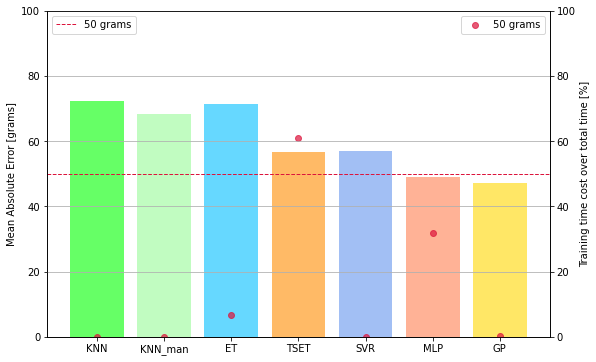

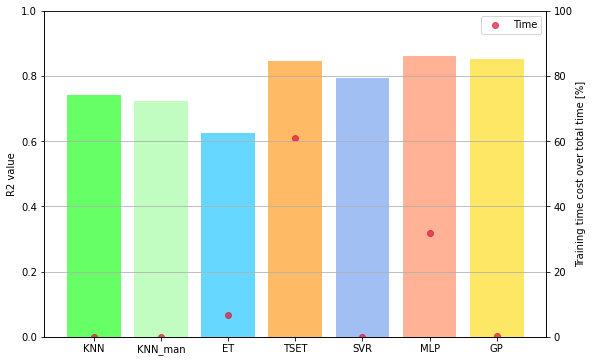

In [ ]:
# Plot of LOOCV results

X = ['KNN', 'KNN_man', 'ET', 'TSET', 'SVR', 'MLP', 'GP']
X_axis = np.arange(len(X))
colors = ["lime", "palegreen", "deepskyblue", "darkorange", "cornflowerblue", "coral", "gold"]

#---- MAE plot
fig, ax = plt.subplots(figsize=(9, 6))

maeLOOCV = np.abs([mae_KNN, mae_KNN_cos, mae_ET, mae_TSET, mae_SVR, mae_MLP, mae_GP])

ax.bar(X_axis, maeLOOCV, color = colors, alpha = 0.6)
ax.axhline(y = 50, color = "crimson", linestyle = "--", linewidth = 1, label = "50 grams")

plt.ylim(0, 100)
plt.xticks(X_axis, X)
plt.ylabel("Mean Absolute Error [grams]")
#plt.title("Leave-One-Out cross validated MAE and training time over the models")
plt.legend(loc = "upper left")

#---- Times plot - MAE
ax2 = ax.twinx()

timeSpent = 100*([time_KNN, time_KNN_cos, time_ET, time_TSET, time_SVR, time_MLP, time_GP]/time_tot)

ax2.scatter(X_axis, timeSpent, label = 'Time', color = "crimson", alpha = 0.7, marker = "o")

plt.ylim(0, 100)
plt.ylabel("Training time cost over total time [%]")
plt.legend(loc = "upper right")
plt.grid()
plt.legend(["50 grams"])

plt.show()

#---- R2 plot
fig, ax3 = plt.subplots(figsize=(9, 6))

r2LOOCV = [r2_KNN, r2_KNN_cos, r2_ET, r2_TSET, r2_SVR, r2_MLP, r2_GP]

ax3.bar(X_axis, r2LOOCV, label = 'R2', color = colors, alpha = 0.6)

plt.ylim(0, 1)
plt.xticks(X_axis, X)
plt.ylabel("R2 value")
#plt.title("Leave-One-Out cross validated R2 and training time over the models")

#---- Times plot - R2
ax4 = ax3.twinx()

timeSpent = 100*([time_KNN, time_KNN_cos, time_ET, time_TSET, time_SVR, time_MLP, time_GP]/time_tot)

ax4.scatter(X_axis, timeSpent, label = 'Time', color = "crimson", alpha = 0.7, marker = "o")

plt.ylim(0, 100)
plt.ylabel("Training time cost over total time [%]")
plt.legend(loc = "upper right")
plt.grid()

plt.show()

In [ ]:
'''
# Create list of our interest
resu = []

for test, svr, et, tset, mlp, knn, knn_cos, gp in zip(Y_w, pred_tar_SVR_r, pred_tar_ET_r, pred_tar_TSET, pred_tar_MLP_r, pred_tar_KNN_r, pred_tar_KNN_cos_r, pred_tar_GP_r):
  resu.append([test, svr, et, tset, mlp, knn, knn_cos, gp])

# Sort list
resu_sorted = sorted(resu, key=lambda l:l[0], reverse=False)

# Get lists back
Y_w_test_s = []
Y_w_pred_SVR_s = []
Y_w_pred_ET_s = []
Y_w_pred_TSET_s = []
Y_w_pred_MLP_s = []
Y_w_pred_KNN_s = []
Y_w_pred_KNN_cos_s = []
Y_w_pred_GP_s = []

for elem in resu_sorted:
  Y_w_test_s.append(elem[0])
  Y_w_pred_SVR_s.append(elem[1])
  Y_w_pred_ET_s.append(elem[2])
  Y_w_pred_TSET_s.append(elem[3])
  Y_w_pred_MLP_s.append(elem[4])
  Y_w_pred_KNN_s.append(elem[5])
  Y_w_pred_KNN_cos_s.append(elem[6])
  Y_w_pred_GP_s.append(elem[7])

resu = [Y_w_pred_SVR_s, Y_w_pred_ET_s, Y_w_pred_TSET_s, Y_w_pred_MLP_s, Y_w_pred_KNN_s, Y_w_pred_KNN_cos_s, Y_w_pred_GP_s]
'''
resu = [pred_tar_KNN_r, pred_tar_KNN_cos_r, pred_tar_ET_r, pred_tar_TSET, pred_tar_SVR_r, pred_tar_MLP_r, pred_tar_GP_r]

In [ ]:
xlab = []
for i in range(len(Y_w)):
  xlab.append(" ")

Text(0, 0.5, 'Weight in grams')

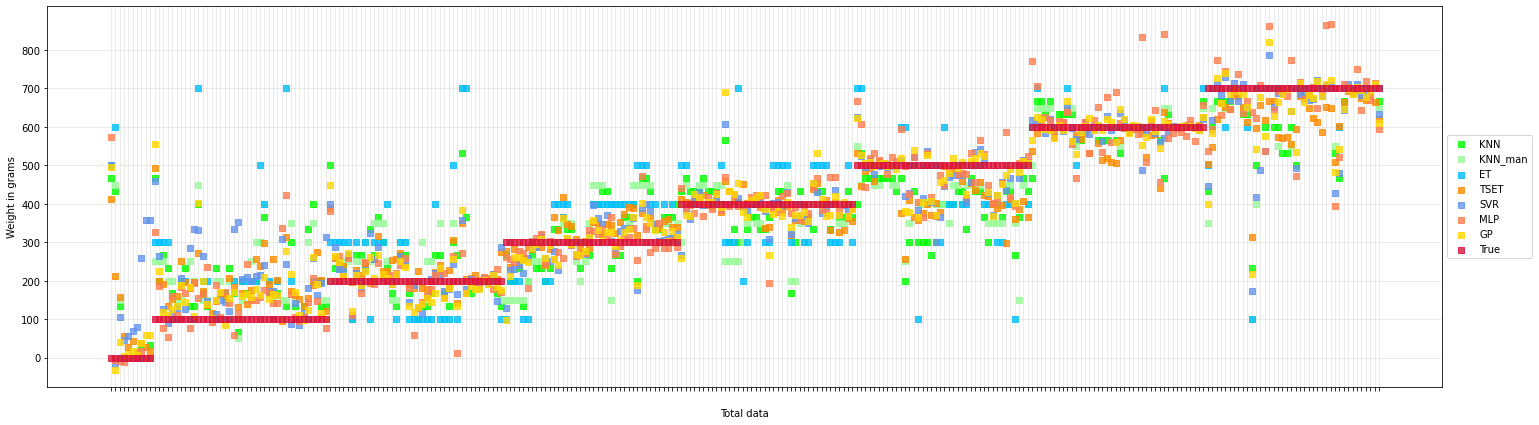

In [ ]:
# LOOCV results: Plot comparasion between predictions of every model 
colors = ["lime", "palegreen", "deepskyblue", "darkorange", "cornflowerblue", "coral", "gold"]

plt.figure(figsize=(25,7))
for r, c in zip(resu, colors):
  plt.scatter(np.arange(len(Y_w)), r, color = c, alpha = 0.8, marker = "s", zorder=3)
  #plt.plot(r, color = c, alpha = 0.7, zorder = 3)
#plt.plot(Y_w_test_s, color = "crimson", zorder = 3, linewidth = 2)
plt.scatter(np.arange(len(Y_w)), Y_w, color = "crimson", marker = "s", alpha = 0.8, zorder = 5)
plt.grid(zorder=0, alpha = 0.3)
plt.yticks([0, 100, 200, 300, 400, 500, 600, 700, 800])
plt.xticks(range(len(Y_w)), xlab)
plt.legend(['KNN', 'KNN_man', 'ET', 'TSET', 'SVR', 'MLP', 'GP', 'True'], loc='center left', bbox_to_anchor=(1, 0.5))
#plt.title("LOOCV predictions for each regressor")
plt.xlabel("Total data")
plt.ylabel("Weight in grams")

Text(0, 0.5, 'Weight in grams')

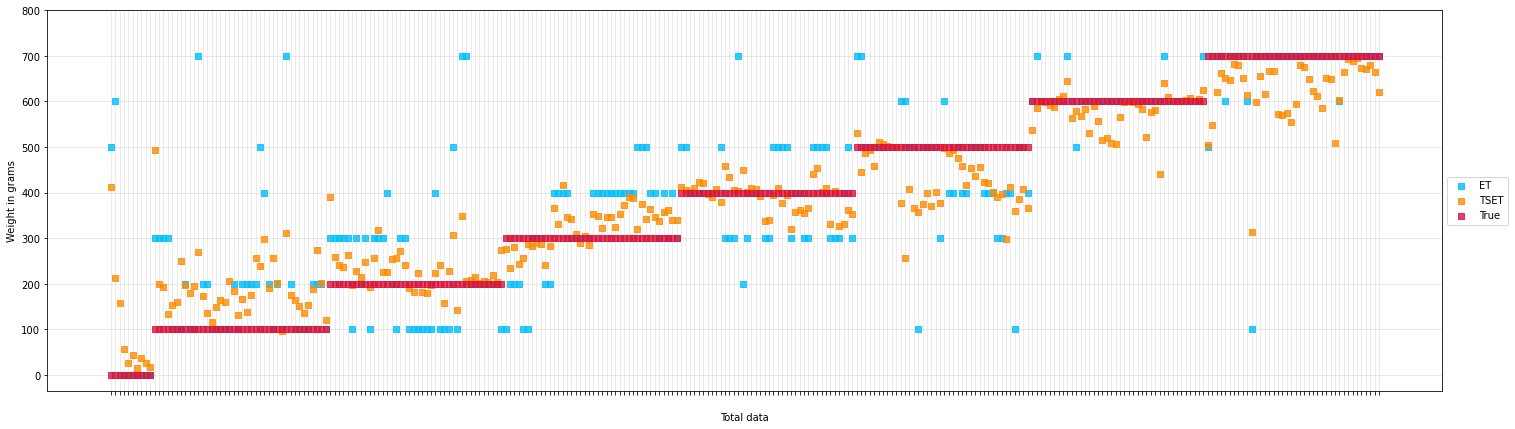

In [ ]:
# LOOCV results: Plot comparasion between predictions of every model 
colors = ["deepskyblue", "darkorange"]

plt.figure(figsize=(25,7))
for r, c in zip([pred_tar_ET_r, pred_tar_TSET], colors):
  plt.scatter(np.arange(len(Y_w)), r, color = c, alpha = 0.8, marker = "s", zorder=3)
plt.scatter(np.arange(len(Y_w)), Y_w, color = "crimson", marker = "s", alpha = 0.8, zorder = 5)
plt.grid(zorder=0, alpha = 0.3)
plt.yticks([0, 100, 200, 300, 400, 500, 600, 700, 800])
plt.xticks(range(len(Y_w)), xlab)
plt.legend(['ET', 'TSET', 'True'], loc='center left', bbox_to_anchor=(1, 0.5))
#plt.title("LOOCV predictions for ET and TSET regressors")
plt.xlabel("Total data")
plt.ylabel("Weight in grams")

Text(0, 0.5, 'Weight in grams')

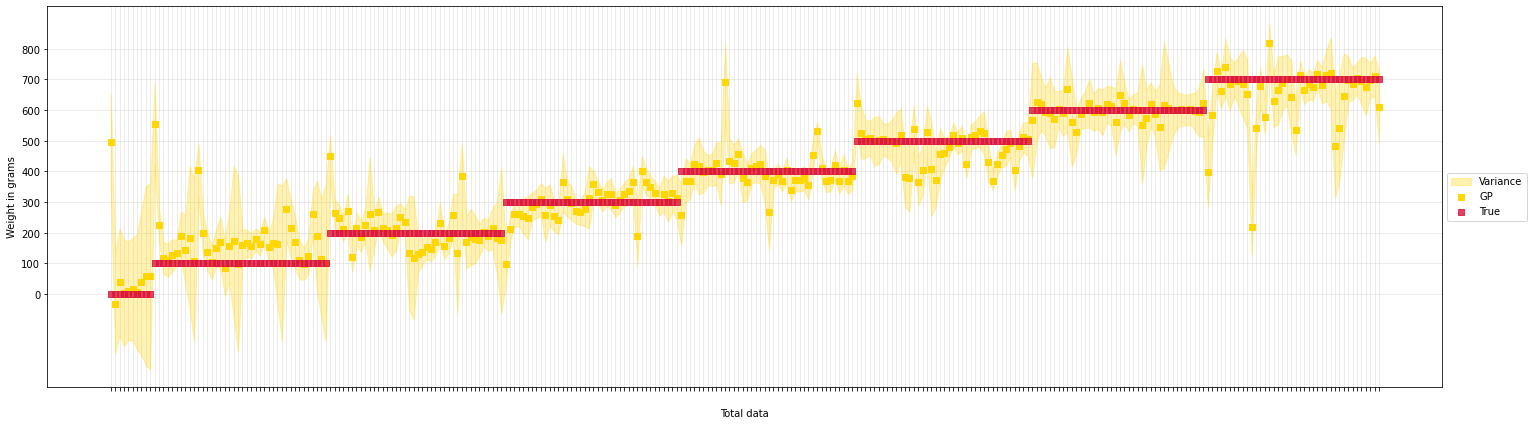

In [ ]:
# LOOCV results: Plot comparasion between predictions of GP model 

std_up = np.add(pred_tar_GP_r, pred_tar_std_GP).reshape(len(Y_w))
std_down = np.subtract(pred_tar_GP_r, pred_tar_std_GP).reshape(len(Y_w))

plt.figure(figsize=(25,7))
plt.fill_between(np.arange(len(Y_w)), std_up, std_down, color='gold', alpha=0.3, zorder=3, label = "Variance")
plt.scatter(np.arange(len(Y_w)), pred_tar_GP_r, color = "gold", alpha = 1.0, marker = "s", zorder=3, label = "GP")
#plt.plot(r, color = c, alpha = 0.7, zorder = 3)
#plt.plot(Y_w_test_s, color = "crimson", zorder = 3, linewidth = 2)
plt.scatter(np.arange(len(Y_w)), Y_w, color = "crimson", marker = "s", alpha = 0.8, zorder = 5, label = "True")
plt.grid(zorder=0, alpha = 0.3)
plt.yticks([0, 100, 200, 300, 400, 500, 600, 700, 800])
plt.xticks(range(len(Y_w)), xlab)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.title("LOOCV predictions for GP regressor")
plt.xlabel("Total data")
plt.ylabel("Weight in grams")

# Export models

## Train pipelines

In [ ]:
# Train best classifier
clf = OneVsOneClassifier(SVC(kernel = 'rbf', C = 215.44346900318823, gamma = 0.01))
clf = clf.fit(X_p, Y_p)

# Train best regressor
reg = GaussianProcessRegressor(kernel = ConstantKernel()*RationalQuadratic() + WhiteKernel(), n_restarts_optimizer = 20)
reg = reg.fit(X_w, Y_w)

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


In [ ]:
class preprocess_clf(TransformerMixin):
  def __init__(self):
    pass

  def fit(self, X, y=None):
    return self

  def transform(self, df_filt):
    # Erase first column because the sensor gives erratic values due to IMU sensor
    df_filt = df_filt.copy()
    del df_filt['i -i_r_o0']

    # Apply a FIR filter to smooth the peaks
    for idx, cycle in enumerate(df_filt.values.tolist()):
      n = 2 # The larger n is, the smoother curve will be
      b = [1.0 / n] * n
      a = 1
      y = cycle
      yy = lfilter(b,a,y)
      df_filt.iloc[idx] = yy
    return df_filt.values

class preprocess_reg(TransformerMixin):
  def __init__(self):
    pass

  def fit(self, X, y=None):
    return self

  def transform(self, df_filt):
    # Erase first column because the sensor gives erratic values due to IMU sensor
    df_filt = df_filt.copy()
    del df_filt['i -i_r_o0']

    # Apply a FIR filter to smooth the peaks
    for idx, cycle in enumerate(df_filt.values.tolist()):
      n = 2 # The larger n is, the smoother curve will be
      b = [1.0 / n] * n
      a = 1
      y = cycle
      yy = lfilter(b,a,y)
      df_filt.iloc[idx] = yy
    return df_filt.values

In [ ]:
# Create pipeline for classification
pipe_clf = Pipeline(steps = (['preprocess', preprocess_clf()],
                             ['scaler', StandardScaler()],
                             ['classifier', clf]))

# Create pipeline for regression
pipe_reg = Pipeline(steps = (['preprocess', preprocess_reg()],
                             ['scaler', StandardScaler()],
                             ['regressor', reg]))

In [ ]:
df_pipe = df.T
df_pipe_clf = df_pipe[2:].T
df_pipe_reg = df_pipe[1:].T

pipe_clf.fit(df_pipe_clf, Y_p)

pipe_reg.fit(df_pipe_reg, Y_w)

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


Pipeline(steps=[('preprocess',
                 <__main__.preprocess_reg object at 0x7efcaf8bdd10>),
                ('scaler', StandardScaler()),
                ['regressor',
                 GaussianProcessRegressor(kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1),
                                          n_restarts_optimizer=20)]])

In [ ]:
joblib.dump(pipe_clf, '/content/drive/MyDrive/Pesos_Cuello/model_position.joblib')
joblib.dump(pipe_reg, '/content/drive/MyDrive/Pesos_Cuello/model_weight.joblib')

['/content/drive/MyDrive/Pesos_Cuello/model_weight.joblib']

## Predict

In [ ]:
# Number of row of dataframe
seq = 89

In [ ]:
# Ground truth
df_truth = df.T
df_truth = pd.DataFrame(df_truth[seq])
df_truth.T

,w,p,i,i -i_r_o0,i -i_r_o1,i -i_r_o2,i -i_r_o3,i -i_r_o4,i -i_r_o5,i -i_r_o6,...,i -i_r_o26,i -i_r_o27,i -i_r_o28,i -i_r_o29,i -i_r_o30,i -i_r_o31,i -i_r_o32,i -i_r_o33,i -i_r_o34,i -i_r_o35
89,200.0,3.0,50.0,9.53347,5.001642,5.578622,5.966934,5.596266,5.55648,3.330152,...,5.543996,6.06323,7.07682,8.413918,9.203892,11.796899,12.816531,12.959557,12.428887,10.625257


In [ ]:
df_to_predict = df_pipe_clf.T
df_to_predict = pd.DataFrame(df_to_predict[seq])
df_to_predict = df_to_predict.T
df_to_predict

,i,i -i_r_o0,i -i_r_o1,i -i_r_o2,i -i_r_o3,i -i_r_o4,i -i_r_o5,i -i_r_o6,i -i_r_o7,i -i_r_o8,...,i -i_r_o26,i -i_r_o27,i -i_r_o28,i -i_r_o29,i -i_r_o30,i -i_r_o31,i -i_r_o32,i -i_r_o33,i -i_r_o34,i -i_r_o35
89,50.0,9.53347,5.001642,5.578622,5.966934,5.596266,5.55648,3.330152,2.551494,0.720521,...,5.543996,6.06323,7.07682,8.413918,9.203892,11.796899,12.816531,12.959557,12.428887,10.625257


In [ ]:
prediction_clf = pipe_clf.predict(df_to_predict)

In [ ]:
df_to_predict = df_pipe_reg.T
df_to_predict = pd.DataFrame(df_to_predict[seq])
df_to_predict = df_to_predict.T
del df_to_predict['p']
df_to_predict.insert(0, 'p', prediction_clf)
df_to_predict

,p,i,i -i_r_o0,i -i_r_o1,i -i_r_o2,i -i_r_o3,i -i_r_o4,i -i_r_o5,i -i_r_o6,i -i_r_o7,...,i -i_r_o26,i -i_r_o27,i -i_r_o28,i -i_r_o29,i -i_r_o30,i -i_r_o31,i -i_r_o32,i -i_r_o33,i -i_r_o34,i -i_r_o35
89,3,50.0,9.53347,5.001642,5.578622,5.966934,5.596266,5.55648,3.330152,2.551494,...,5.543996,6.06323,7.07682,8.413918,9.203892,11.796899,12.816531,12.959557,12.428887,10.625257


In [ ]:
prediction_reg = pipe_reg.predict(df_to_predict)

In [ ]:
print("LOAD ESTIMATION\n-----------------\nPOSITION: %.2f\nWEIGHT: %.2f g" %(float(prediction_clf), float(prediction_reg)))

LOAD ESTIMATION
-----------------
POSITION: 3.00
WEIGHT: 199.75 g
